## Load libraries

In [ ]:
!pip install comet_ml

In [ ]:
from comet_ml import Experiment

In [ ]:
experiment = Experiment(#api_key=YOUR API KEY HERE, project_name='', workspace='')

In [ ]:
#MOVE THIS CELL WHERE APPROPRIATE
#Check "Comet starter notebook" preprocessing for more info
#Remember to save new parameters and metrics in a dictionary for logging
#params = {}
#metrics = {}

#Log parameters and results
#experiment.log_parameters(params)
#experiment.log_metrics(metrics)

In [ ]:
#MOVE THIS CELL WHERE APPROPRIATE
#Check "Comet starter notebook" preprocessing for more info
#experiment.end()

In [30]:
import numpy as np
import pandas as pd
import spacy
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
nlp = spacy.load('en_core_web_lg')

In [32]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import wordcloud

In [ ]:
from wordcloud import WordCloud

## Load data

In [33]:
df = pd.read_csv('train.csv')
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


## Data preprocessing

In [ ]:
#Things to consider:
#Remove 'RT ', '@___:', '#', 'urls'
#How does spelling affect the analysis?

In [34]:
print(len(df))
print(len(set(df['message'])))
print(df.isna().sum())

15819
14229
sentiment    0
message      0
tweetid      0
dtype: int64


In [35]:
#Drop duplicate tweets
df = df.drop_duplicates(['message'])
print(df.head())
print(len(df))
print(len(set(df['message'])))

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954
14229
14229


In [36]:
#Remove spaces after hashtags
for i in range(len(df)):
    for j in re.finditer('# ', df.iloc[i, 1]):
        if j.span() is not None:
            df.iloc[i, 1] = re.sub(df.iloc[i, 1][j.span()[0]:j.span()[1]], r'#', df.iloc[i, 1])
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker#WIRED : 2016 was a pivotal year ...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [37]:
#Remove hashtags, mentions and urls
regex_pattern = ['#[\w]*', '@[\w]*:', '@[\w]*', '((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*']
for i in range(len(df)):
    for j in range(len(regex_pattern)):
        for k in re.finditer(regex_pattern[j], df.iloc[i, 1]):
            if k.span() is not None:
                df.iloc[i, 1] = re.sub(k.group().strip(), '', df.iloc[i, 1])
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT Researchers say we have three years to act...,698562
3,1,: 2016 was a pivotal year in the war on clima...,573736
4,1,"RT It's 2016, and a racist, sexist, climate c...",466954


In [38]:
#Reduce strings of repeated letters down to 2 eg looooooooove becomes loove (easier to correct later)
for i in range(len(df)):
    df.iloc[i, 1] = re.sub(r'([a-z])\1+', r'\1\1', df.iloc[i, 1])
    df.iloc[i, 1] = re.sub(r':', r'', df.iloc[i, 1])
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT Researchers say we have three years to act...,698562
3,1,2016 was a pivotal year in the war on climat...,573736
4,1,"RT It's 2016, and a racist, sexist, climate c...",466954


In [ ]:
#print(nlp.Defaults.stop_words)

In [39]:
#Remove stop words from messages. Make a second column of message because code removes capital letters.
df['msg_stop_removed'] = df['message']
df['msg_stop_removed'] = df.msg_stop_removed.str.replace("[^\w\s]", "").str.lower()
df['msg_stop_removed'] = df['msg_stop_removed'].apply(lambda x: ' '.join([item for item in x.split() if item not in nlp.Defaults.stop_words]))
df.head()

,sentiment,message,tweetid,msg_stop_removed
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2,RT Researchers say we have three years to act...,698562,rt researchers years act climate change late
3,1,2016 was a pivotal year in the war on climat...,573736,2016 pivotal year war climate change
4,1,"RT It's 2016, and a racist, sexist, climate c...",466954,rt 2016 racist sexist climate change denying b...


In [ ]:
tokens_without_sw = [word for word in word_tokenize(text) if not word in nlp.Defaults.stop_words]

In [40]:
slang = pd.read_csv('SlangSD.txt', sep='\t', names=['word', 'score'])

In [41]:

sid = SentimentIntensityAnalyzer()

In [42]:
slang_dict = dict(zip(slang['word'], slang['score']))

In [43]:
sid.lexicon.update(slang_dict)

In [44]:
from nltk.corpus.reader import WordListCorpusReader
from nltk.corpus.reader.api import *

In [45]:
from nltk.corpus import opinion_lexicon

In [46]:
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [47]:
opinion_lexicon.negative()

['2-faced', '2-faces', 'abnormal', 'abolish', ...]

## Feature engineering

In [48]:
df['length'] = df['message'].apply(lambda i: len(i))
df.head()

,sentiment,message,tweetid,msg_stop_removed,length
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,108
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,62
2,2,RT Researchers say we have three years to act...,698562,rt researchers years act climate change late,88
3,1,2016 was a pivotal year in the war on climat...,573736,2016 pivotal year war climate change,55
4,1,"RT It's 2016, and a racist, sexist, climate c...",466954,rt 2016 racist sexist climate change denying b...,91


In [49]:
df['compound']  = df['message'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['compound'])
df.head()

,sentiment,message,tweetid,msg_stop_removed,length,compound
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,108,0.2261
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,62,0.5109
2,2,RT Researchers say we have three years to act...,698562,rt researchers years act climate change late,88,-0.8286
3,1,2016 was a pivotal year in the war on climat...,573736,2016 pivotal year war climate change,55,-0.2500
4,1,"RT It's 2016, and a racist, sexist, climate c...",466954,rt 2016 racist sexist climate change denying b...,91,-0.4824


In [56]:
#Imbalanced data
df['sentiment'].value_counts()

 1    7222
 2    3542
 0    2244
-1    1221
Name: sentiment, dtype: int64

In [52]:
'''Balance Data'''



#Separate classes
sent_negative = df[df['sentiment']==-1]
sent_0 = df[df['sentiment']==0]
sent_1 = df[df['sentiment']==1]
sent_two = df[df['sentiment']==2]

In [53]:
#import module
from sklearn.utils import resample

In [54]:
#Resample to match sentiment 2's length

#Downsample majority
sent_one = resample(sent_1, replace=False, n_samples= len(df[df['sentiment']==2]), random_state=27) 

#Upsample minority
sent_zero = resample(sent_0, replace=True, n_samples= len(df[df['sentiment']==2]), random_state=27)
sent_neg = resample(sent_negative, replace=True, n_samples= len(df[df['sentiment']==2]), random_state=27)

#Join resampled classes back together
resampled = pd.concat([sent_one, sent_zero, sent_neg, sent_two])

In [55]:
#Balanced data
resampled['sentiment'].value_counts()

-1    3542
 2    3542
 1    3542
 0    3542
Name: sentiment, dtype: int64

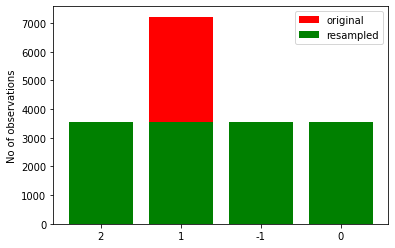

In [59]:
original_heights = [len(sent_negative), len(sent_0), len(sent_1), len(sent_two)]
resampled_heights = [len(sent_one),len(sent_two), len(sent_zero), len(sent_neg)]

labels = df['sentiment'].unique()
plt.bar(labels,original_heights,color='red')
plt.bar(labels,resampled_heights,color='green')
plt.xticks(labels,[-1, 0, 1, 2])
plt.ylabel("No of observations")
plt.legend(['original','resampled'])
plt.show()

## EDA

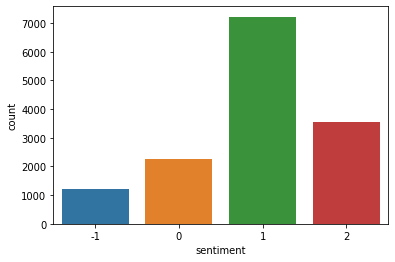

In [50]:
sns.countplot(df['sentiment'])
plt.show()

In [ ]:
#Wordcloud of tweets
wordcloud = WordCloud().generate(' '.join(df[df['sentiment'] == 2]['message']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#Wordcloud of tweets
wordcloud = WordCloud().generate(' '.join(df[df['sentiment'] == 1]['message']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#Wordcloud of tweets
wordcloud = WordCloud().generate(' '.join(df[df['sentiment'] == 0]['message']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#Wordcloud of tweets
wordcloud = WordCloud().generate(' '.join(df[df['sentiment'] == -1]['message']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Data cleaning

In [ ]:
df[df['sentiment'] == 1]['message'].head()

## Modelling

## Model evaluation